In [9]:
"""
Assignment 3 - clustering
"""
from collections import Counter
import time
import sys
import pdb
sys.path.append("C:\\users\\mccar\\miniconda3\\lib\\site-packages")
import numpy as np
import pandas as pd
import os
import warnings
import umap
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, silhouette_score, mutual_info_score, mean_squared_error
from sklearn.model_selection import validation_curve, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.manifold import TSNE
from scipy.stats import kurtosis
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness
from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib import cm


In [10]:
# get data
DATA_PATH = "data/mnist/mnist_train.csv"
train_df = pd.read_csv(DATA_PATH)
DATA_PATH = "data/mnist/mnist_test.csv"
test_df = pd.read_csv(DATA_PATH)
print(train_df.shape)

y_train = train_df["label"]
x_train = train_df.drop(["label"], axis=1)
y_test = test_df["label"]
x_test = test_df.drop(["label"], axis=1)

x_train_sc = x_train

(60000, 785)


In [11]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_train)

In [12]:
# K Means

run = False
if run:
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_train_sc)
        wcss.append(kmeans.inertia_)
        print("{}   {}".format(k, wcss[-1]))
        # labels = kmeans.labels_
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

    # Plot the silhouette scores vs. K
    plt.plot(k_range, wcss, marker='o')
    plt.title('KMeans MNIST - WCSS  vs. Number of Clusters (K)')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Within Cluster Sum of Squares')
    plt.xticks(k_range)
    plt.grid(True)
    plt.savefig("pngs/mnist/kmeans_wcss.png")
    plt.show()

In [13]:
#TODO Analyze which clusters at 8 are overlapping

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

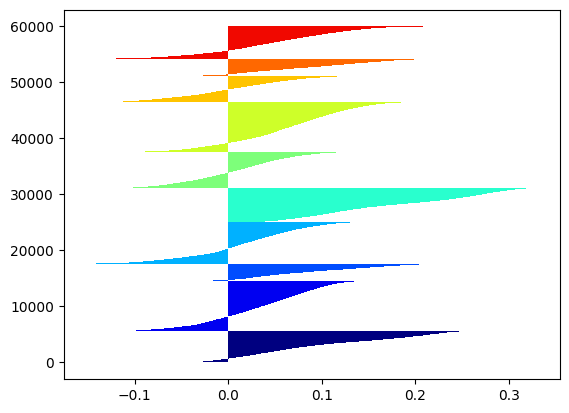

In [16]:
run = True

if run:
    km = KMeans(n_clusters=10, 
                init='k-means++', 
                n_init=10, 
                max_iter=300,
                tol=1e-04,
                random_state=0)
    y_km = km.fit_predict(x_train_sc)

    cluster_labels = np.unique(y_km)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(x_train_sc, y_km, metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
                edgecolor='none', color=color)

        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
        
    silhouette_avg = np.mean(silhouette_vals)
    plt.title('KMeans MNIST - Silhouette Plot')
    plt.axvline(silhouette_avg, color="red", linestyle="--") 
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.savefig("pngs/mnist/kmeans_silhouette.png")
    plt.show()

In [6]:
# Expectation Maximation (EM) Clustering

run = False
if run:
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Calculate silhouette scores for different values of K
    silhouette_scores = []
    start_time = time.time()
    log_likelihoods = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_train_sc)
        log_likelihoods.append(gmm.score(x_train_sc))
        # labels = gmm.predict(x_train_sc)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)
        execution_time = time.time() - start_time
        # Print out the execution time
        print("Execution time:", execution_time, "seconds")
        print("Trustworthiness score:", log_likelihoods[-1])

    # Plot the silhouette scores vs. K
    plt.plot(k_range, log_likelihoods, marker='o')
    plt.title('MNIST Log Likelihood vs. Number of Clusters (K) EM')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Log Likelihood')
    plt.xticks(k_range)
    plt.grid(True)
    plt.savefig("pngs/mnist/em_loglike.png")
    plt.show()

In [7]:
# PCA

# Fit PCA to the data
run = False
if run:
    pca = PCA()
    pca.fit(x_train_sc)
    x_pca = pca.fit_transform(x_train_sc)

    # Get the explained variance (eigenvalues) for each principal component
    eigenvalues = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(eigenvalues)
    print(eigenvalues)
    print(sum(eigenvalues))
    print(len(eigenvalues))

    # Plotting
    fig, ax1 = plt.subplots()

    # Bar plot for explained variance
    ax1.bar(np.arange(len(eigenvalues)), eigenvalues, color='b', alpha=0.5)
    ax1.set_xlabel('Principal Components')
    ax1.set_ylabel('Explained Variance Ratio', color='b')

    # Line plot for cumulative explained variance
    ax2 = ax1.twinx()
    ax2.plot(np.arange(len(cumulative_explained_variance)), cumulative_explained_variance, color='r')
    ax2.set_ylabel('Cumulative Explained Variance Ratio', color='r')

    plt.title('MNIST PCA Analysis')
    plt.savefig("pngs/mnist/pca_analysis.png")
    plt.show()

    # Plot the original clusters with colors
    plt.figure(figsize=(10, 6))
    plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('MNIST PCA Components with Colored Clusters')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.savefig("pngs/mnist/pca_2d.png")
    plt.show()

    # Plot the original clusters with colors in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_pca[:, 0], x_pca[:, 1], x_pca[:, 2], c=y_encoded, cmap='viridis', alpha=0.5)
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.set_title('PCA Components with Colored Clusters')
    plt.savefig("pngs/mnist/pca_3d.png")
    plt.show()

In [8]:
# ICA
run = False
if run:
    # Fit ICA to the data
    ica = FastICA(n_components=2)
    x_ica = ica.fit_transform(x_train_sc)
    
    # Get the independent components
    components = ica.components_

    # Plot the original clusters with colors
    plt.figure(figsize=(10, 6))
    plt.scatter(x_ica[:, 0], x_ica[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
    plt.xlabel('Independent Component 1')
    plt.ylabel('Independent Component 2')
    plt.title('MNIST ICA Components with Colored Clusters')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.savefig("pngs/mnist/ica_2d.png")
    plt.show()

    # Fit ICA to the data
    ica = FastICA(n_components=3)
    x_ica = ica.fit_transform(x_train_sc)
    
    # Get the independent components
    components = ica.components_
    # Plot the original clusters with colors in 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_ica[:, 0], x_ica[:, 1], x_ica[:, 2], c=y_encoded, cmap='viridis', alpha=0.5)
    ax.set_xlabel('Independent Component 1')
    ax.set_ylabel('Independent Component 2')
    ax.set_zlabel('Independent Component 3')
    ax.set_title('MNIST ICA Components with Colored Clusters')
    plt.savefig("pngs/mnist/ica_3d.png")
    plt.show()


    kurts = []
    max_comp = 150
    for k in range(2, max_comp):
        ica = FastICA(n_components=k, random_state=42)
        ica.fit(x_train_sc)
        x_ica = ica.transform(x_train_sc)
        kurts.append(sum(kurtosis(x_ica)))
        print("epoch: ", k)
        print("kurtosis: ", kurts[-1])

    print(kurts)
    plt.plot(range(2, max_comp), kurts, marker='o')
    plt.title('MNIST Kurtosis vs. Number of Independent Components (ICA)')
    plt.xlabel('Number of Independent Components')
    plt.ylabel('Kurtosis')
    plt.grid(True)
    plt.savefig("pngs/mnist/ica_kurtosis.png")
    plt.show()

    # TODO may need to rerun below here?
    kurtosis_quest = True
    if kurtosis_quest:
        def negentropy(x):
            return -np.sum(np.log(np.cosh(x))) - np.sum(np.log(np.sqrt(2 * np.pi * np.exp(1))))

        # Compare before and after transformation
        # 1. Mutual Information (for original data)
        # mutual_info_matrix_original = np.zeros((x_train_sc.shape[1], x_train_sc.shape[1]))
        # for i in range(x_train_sc.shape[1]):
        #     for j in range(x_train_sc.shape[1]):
        #         mutual_info_matrix_original[i, j] = mutual_info_score(x_train_sc[:, i], x_train_sc[:, j])

        # 2. Kurtosis (for original data)
        feature_kurtosis_original = kurtosis(x_train_sc)

        # 3. Calculate negentropy for each feature in the original data
        negentropy_original_values = np.apply_along_axis(negentropy, axis=0, arr=x_train_sc)
    
        # Apply Independent Component Analysis (ICA)
        ica = FastICA(random_state=42)
        ica.fit(x_train_sc)
        # Transform the original data using ICA
        ica_components = ica.transform(x_train_sc)

        # 3. Measures of Non-Gaussianity (Negentropy using ICA)
        # Calculate negentropy for each independent component obtained through ICA
        negentropy_values_transformed = np.apply_along_axis(negentropy, axis=0, arr=ica_components)

        # 4. Mutual Information (for transformed data)
        # mutual_info_matrix_transformed = np.zeros((ica_components.shape[1], ica_components.shape[1]))
        # for i in range(ica_components.shape[1]):
        #     for j in range(ica_components.shape[1]):
        #         mutual_info_matrix_transformed[i, j] = mutual_info_score(ica_components[:, i], ica_components[:, j])

        # 5. Kurtosis (for transformed data)
        component_kurtosis_transformed = kurtosis(ica_components)

In [9]:
run = False
if run:
    print("Before Transformation:")
    # print("Mean Mutual Information:  {}".format(np.mean(mutual_info_matrix_original)))
    print("Mean Kurtosis:           {}".format(np.mean(feature_kurtosis_original)))
    print("Mean Negentropy:         {}".format(np.mean(negentropy_original_values)))
    
    print("After Transformation:")
    # print("Mean Mutual Information:  {}".format(np.mean(mutual_info_matrix_transformed)))
    print("Mean Kurtosis:           {}".format(np.mean(component_kurtosis_transformed)))
    print("Mean Negentropy:         {}".format(np.mean(negentropy_values_transformed)))

In [10]:
# RCA

run = False
if run:
    grp = GaussianRandomProjection(n_components=2, random_state=42)
    x_rc = grp.fit_transform(x_train_sc)
    # Plot the original clusters with colors
    plt.figure(figsize=(10, 6))
    plt.scatter(x_rc[:, 0], x_rc[:, 1], c=y_encoded, cmap='viridis', alpha=0.5)
    plt.xlabel('Random Component 1')
    plt.ylabel('Random Component 2')
    plt.title('MNIST RCA Components with Colored Clusters')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.savefig("pngs/mnist/rca_2d.png")
    plt.show()

    # Plot the original clusters with colors in 3D
    grp = GaussianRandomProjection(n_components=3, random_state=42)
    x_rc = grp.fit_transform(x_train_sc)
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_rc[:, 0], x_rc[:, 1], x_rc[:, 2], c=y_encoded, cmap='viridis', alpha=0.5)
    ax.set_xlabel('Random Component 1')
    ax.set_ylabel('Random Component 2')
    ax.set_zlabel('Random Component 3')
    ax.set_title('MNIST RCA Components with Colored Clusters')
    plt.savefig("pngs/mnist/rca_3d.png")
    plt.show()

In [11]:
# Perform Random Component Analysis (RCA)
run = False
if run:
    r_error = []
    max_comp = 150
    for k in range(2, max_comp):
        rca = GaussianRandomProjection(n_components=k, random_state=42)
        X_rca = rca.fit_transform(x_train_sc)
        X_reconstructed = rca.inverse_transform(X_rca)
        reconstruction_error = mean_squared_error(x_train_sc, X_reconstructed)
        # print("Reconstruction error:", reconstruction_error)
        r_error.append(reconstruction_error)

    plt.plot(range(2, max_comp), r_error, marker='o')
    plt.title('MNIST Reconstruction Error vs. Number of Components (RCA)')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.grid(True)
    plt.savefig("pngs/mnist/rca_reconstruction_error.png")
    plt.show()

In [12]:
# UMAP

# Perform t-SNE
print("Enter")
run = False
if run:
    # Perform UMAP for dimensionality reduction
    # umap_model = umap.UMAP(n_components=2, random_state=42)
    # X_umap = umap_model.fit_transform(x_train_sc)
    # # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(x_train_sc)

    # # Plot the result
    plt.figure(figsize=(8, 6))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_encoded, cmap=plt.cm.get_cmap("viridis", 10))
    plt.colorbar(ticks=range(3), label='Classes')
    plt.title('t-SNE Visualization of MNIST Dataset')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.savefig("pngs/mnist/t-SNE_2d.png")
    plt.show()

    # Perform UMAP for dimensionality reduction
    # umap_model = umap.UMAP(n_components=3, random_state=42)
    # X_umap = umap_model.fit_transform(x_train_sc)
    # # Perform t-SNE
    tsne = TSNE(n_components=3, random_state=42)
    X_tsne = tsne.fit_transform(x_train_sc)

    # # Plot the result
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y_encoded, cmap=plt.cm.get_cmap("viridis", 10))
    ax.set_xlabel('t-SNE Dimension 1')
    ax.set_ylabel('t-SNE Dimension 2')
    ax.set_zlabel('t-SNE Dimension 3')
    ax.set_title('t-SNE Visualization of MNIST Dataset')
    plt.savefig("pngs/mnist/t-SNE_3d.png")
    plt.show()

run = False
abbrev = 10000
if run:
    x_train_abbrev = x_train_sc[:abbrev]
    max_comp = 15
    # Calculate pairwise distances in the original space
    distances_original = pairwise_distances(x_train_abbrev, metric='euclidean')
    # Define the range of components
    component_range = np.arange(2, max_comp)
    # Initialize lists to store scores
    trustworthiness_scores = []
    continuity_scores = []
    start_time = time.time()
    
    # Iterate over different numbers of components
    print("start")
    for n_components in component_range:
        # Perform t-SNE with the current number of components
        umap_model = umap.UMAP(n_components=n_components, random_state=42)
        X_umap = umap_model.fit_transform(x_train_abbrev)
        # tsne = TSNE(n_components=n_components, random_state=42)
        # X_tsne = tsne.fit_transform(x_train_sc)
        
        # Calculate pairwise distances in the t-SNE embedding
        distances_umap = pairwise_distances(X_umap, metric='euclidean')
        
        # Calculate trustworthiness
        trustworthiness_score = trustworthiness(distances_original, distances_umap, n_neighbors=3)
        trustworthiness_scores.append(trustworthiness_score)
        
        execution_time = time.time() - start_time
        # Print out the execution time
        print("Execution time:", execution_time, "seconds")
        print("Trustworthiness score:", trustworthiness_score)
        
        # Calculate continuity manually
        # sorted_indices_original = np.argsort(distances_original, axis=1)[:, 1:6]  # Exclude self-distances
        # sorted_indices_tsne = np.argsort(distances_tsne, axis=1)[:, 1:6]  # Exclude self-distances
        # continuity_score = np.mean(np.in1d(sorted_indices_original, sorted_indices_tsne))
        # continuity_scores.append(continuity_score)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(component_range, trustworthiness_scores, label='Trustworthiness', marker='o')
    # plt.plot(component_range, continuity_scores, label='Continuity', marker='o')
    plt.title('MNIST Trustworthiness of UMAP Embedding')
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.savefig("pngs/mnist/umap_scores.png")
    plt.show()
    

Enter


In [13]:
# PCA Kmeans

run = False
if run:
    pca = PCA(n_components=50)
    # pca.fit(x_train_sc)
    x_pca = pca.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    accuracies = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_pca)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Within Cluster Sum of Squares', color=color)
    ax1.plot(k_range, wcss, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('PCA KMeans MNIST - WCSS and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/mnist/pca_kmeans_wcss_accuracy.png")
    plt.show()

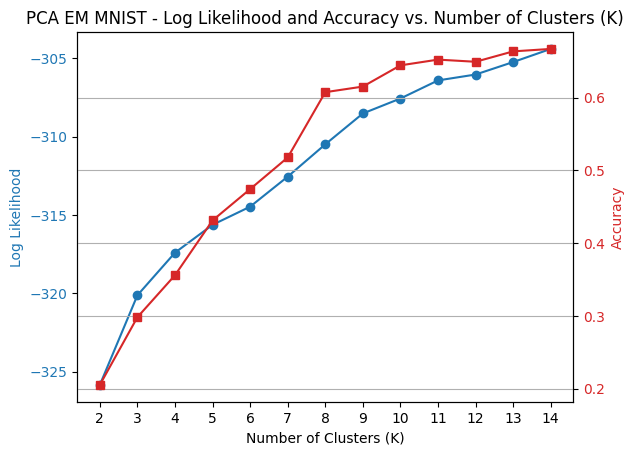

In [20]:
# PCA EM

run = True
if run:
    pca = PCA(n_components=50)
    # pca.fit(x_train_sc)
    x_pca = pca.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

   # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    accuracies = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_pca)
        log_likelihoods.append(gmm.score(x_pca))
        labels = gmm.predict(x_pca)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Log Likelihood', color=color)
    ax1.plot(k_range, log_likelihoods, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('PCA EM MNIST - Log Likelihood and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/mnist/pca_em_loglike_accuracy.png")
    plt.show()

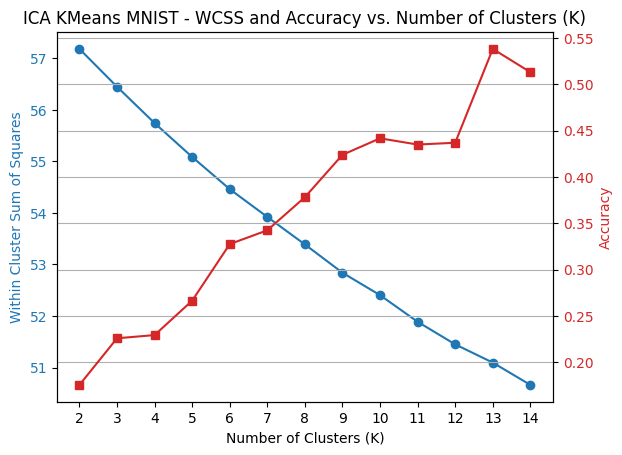

: 

In [26]:
# ICA KMeans

run = True
if run:
    ica = FastICA(n_components=63)
    x_ica = ica.fit_transform(x_train_sc)

    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    accuracies = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_ica)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

    # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Within Cluster Sum of Squares', color=color)
    ax1.plot(k_range, wcss, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('ICA KMeans MNIST - WCSS and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/mnist/ica_kmeans_wcss_accuracy.png")
    plt.show()

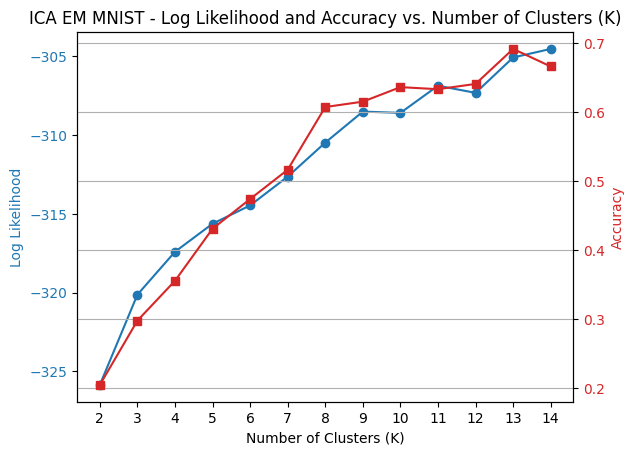

In [24]:
# ICA EM

run = True
if run:
    ica = FastICA(n_components=63)
    x_ica = ica.fit_transform(x_train_sc)

    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    accuracies = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_pca)
        log_likelihoods.append(gmm.score(x_pca))
        labels = gmm.predict(x_pca)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Log Likelihood', color=color)
    ax1.plot(k_range, log_likelihoods, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('ICA EM MNIST - Log Likelihood and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/mnist/ica_em_loglike_accuracy.png")
    plt.show()

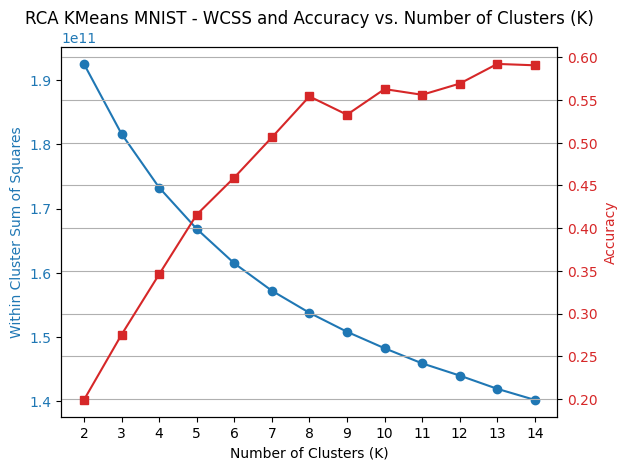

In [17]:
# RCA KMeans

run = False
if run:
    grp = GaussianRandomProjection(n_components=65, random_state=42)
    x_rc = grp.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    accuracies = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(x_rc)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Within Cluster Sum of Squares', color=color)
    ax1.plot(k_range, wcss, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('RCA KMeans MNIST - WCSS and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/mnist/rca_kmeans_wcss_accuracy.png")
    plt.show()

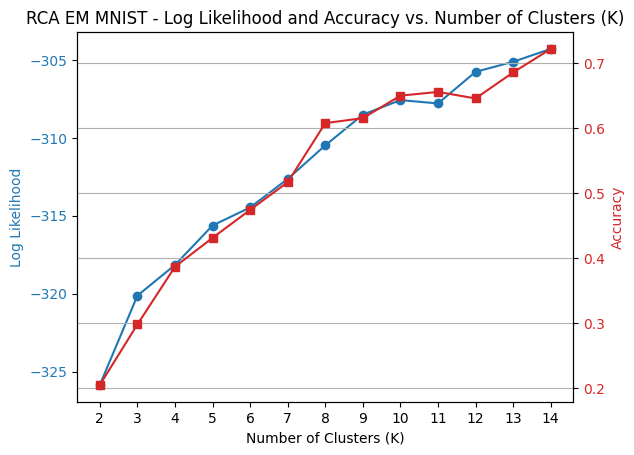

In [22]:
# RCA EM

run = True
if run:
    grp = GaussianRandomProjection(n_components=65, random_state=42)
    x_rc = grp.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    accuracies = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_pca)
        log_likelihoods.append(gmm.score(x_pca))
        labels = gmm.predict(x_pca)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Log Likelihood', color=color)
    ax1.plot(k_range, log_likelihoods, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('RCA EM MNIST - Log Likelihood and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/mnist/rca_em_loglike_accuracy.png")
    plt.show()

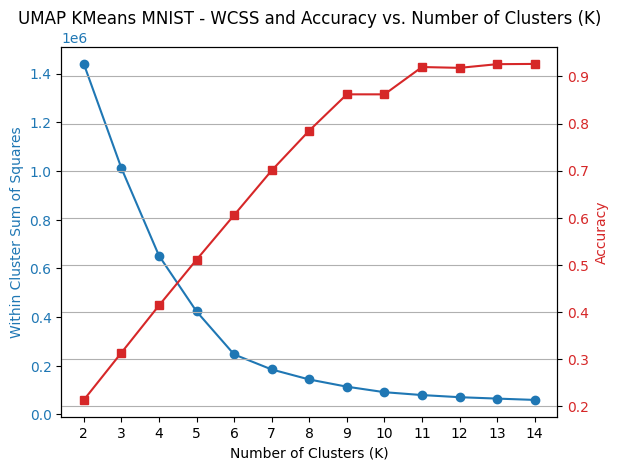

In [19]:
# UMAP KMeans

run = False
if run:
    umap_model = umap.UMAP(n_components=6, random_state=42)
    X_umap = umap_model.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Plotting the clustering results for varying numbers of clusters
    silhouette_scores = []
    wcss = []
    accuracies = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_umap)
        labels = kmeans.labels_
        wcss.append(kmeans.inertia_)
        # score = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(score)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Within Cluster Sum of Squares', color=color)
    ax1.plot(k_range, wcss, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('UMAP KMeans MNIST - WCSS and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/mnist/umap_kmeans_wcss_accuracy.png")
    plt.show() 

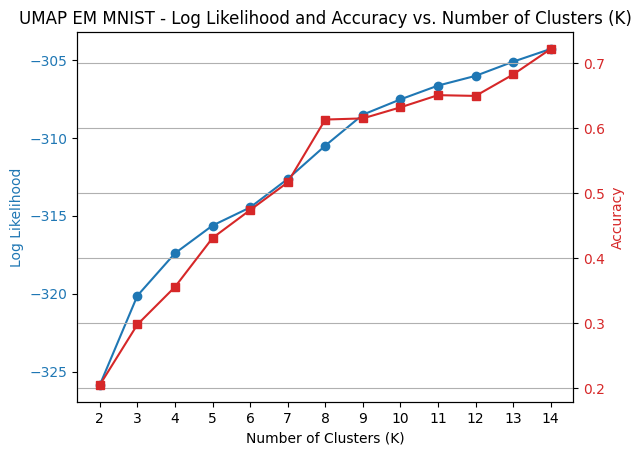

In [23]:
# UMAP EM

run = True
if run:
    umap_model = umap.UMAP(n_components=6, random_state=42)
    X_umap = umap_model.fit_transform(x_train_sc)
    # Define the range of cluster numbers (K)
    k_range = range(2, 15)

    # Calculate silhouette scores for different values of K
    silhouette_scores = []
    log_likelihoods = []
    accuracies = []
    for k in k_range:
        gmm = GaussianMixture(n_components=k)
        gmm.fit(x_pca)
        log_likelihoods.append(gmm.score(x_pca))
        labels = gmm.predict(x_pca)
        # silhouette_avg = silhouette_score(x_train_sc, labels)
        # silhouette_scores.append(silhouette_avg)

        # Find the most frequent label within each cluster
        cluster_labels = {}
        for cluster in range(k):
            cluster_labels[cluster] = Counter(y_train[labels == cluster]).most_common(1)[0][0]
        
        # Assign the most frequent label to all data points within each cluster
        assigned_labels = [cluster_labels[cluster] for cluster in labels]
        
        # Calculate accuracy using assigned labels
        accuracy = accuracy_score(y_train, assigned_labels)
        accuracies.append(accuracy)

    # Plotting
    fig, ax1 = plt.subplots()

    # Plot WCSS
    color = 'tab:blue'
    ax1.set_xlabel('Number of Clusters (K)')
    ax1.set_ylabel('Log Likelihood', color=color)
    ax1.plot(k_range, log_likelihoods, marker='o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()  
    color = 'tab:red'
    ax2.set_ylabel('Accuracy', color=color)
    ax2.plot(k_range, accuracies, marker='s', color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    # Add title and grid
    plt.title('UMAP EM MNIST - Log Likelihood and Accuracy vs. Number of Clusters (K)')
    plt.xticks(k_range)
    plt.grid(True)

    # Save and show plot
    plt.savefig("pngs/mnist/umap_em_loglike_accuracy.png")
    plt.show()

In [ ]:
# Define function to create and compile the model
def create_model(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Function to train and evaluate the model
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
    return history.history

# Plot learning curves
plt.figure(figsize=(12, 8))

for i, dataset in enumerate(datasets):
    X = dataset.data
    y = dataset.target

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Create and compile the model
    model = create_model(input_shape=X_train.shape[1:])

    # Train and evaluate the model
    history = train_and_evaluate(model, X_train, y_train, X_test, y_test)

    # Plot learning curves
    plt.subplot(2, 2, i+1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Dataset {i+1} Learning Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()